<hr>
<h1><font size = "+6"> <b>House Price Predictor</b></font></h1>
<hr>

# I. Getting Started
<hr>

In [338]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
import math
sns.set()
# plt.style.use("dark_background")
warnings.filterwarnings('ignore')
%matplotlib inline

In [339]:
train_df = pd.read_csv("house-prices-advanced-regression-techniques\\train.csv")

In [340]:
test_df = pd.read_csv("house-prices-advanced-regression-techniques\\test.csv")

In [341]:
ids = test_df["Id"]

##### Pre-defined function template
Ignore below code cell !

In [342]:
# Helper Functions -- Jump to code cell below
def get_scatterplot(df, var, col = 10, row = 7):
    plt.figure(figsize=(col, row))
    data = pd.concat([df[var], df[target]], axis = 1)
    sns.scatterplot(data = data, x = var, y = target)

def get_boxplot(df, x, y = None, col = 10, row = 7):
    plt.figure(figsize=(col, row))
    data = pd.concat([df[x], df[target]], axis = 1)
    if y == None:
        sns.boxplot(data = data, x = x)
    else:
        sns.boxplot(data = data, x = x, y = y)

def get_heatmap(correlations, theme = "bwr", col = 15, row = 15, round_off = 1, annot = False):
    plt.figure(figsize=(col, row))
    round_off = str(round_off)
    sns.heatmap(correlations, square = True, cmap = theme, fmt = "." + round_off + "f", annot = annot, center = 0, linecolor ="white")

def get_correlated(df, k = 10, plot = True, theme = "bwr", col = 15, row = 15, round_off = 1, annot = False):
    cols = df.corr().nlargest(k, target)[target]
    if plot == True:
        get_heatmap(df[cols.index].corr(), theme, col, row, round_off, annot)
    return cols

def get_pairplot(df, vars, col = 15, row = 15, size = 2.5):
    plt.figure(figsize=(col, row))
    sns.pairplot(df[vars], size = size)

# Set kde = False to disable line.
def get_distplot(df, var, kde = True, fit = None):
    sns.distplot(df[var], kde = kde, fit = fit)
    return {"Skewness" : df[var].skew(), "Kurtosis" : df[var].kurt()}

# Returns categorical cols, numeric cols, and labelled dataframe consisting of both.
def identify_columns(df):
    categorical = [col for col in df.columns if df[col].dtype == 'O']
    numeric = [col for col in df.columns if df[col].dtype != 'O']
    return categorical, numeric

### Initial Dataset Analysis

In [343]:
train_df.shape, test_df.shape

((1460, 81), (1459, 80))

In [344]:
categorical, numeric = identify_columns(train_df)
print("{} Numeric features : {} \n{} Categorical features : {}".format(len(numeric), numeric,len(categorical), categorical))

38 Numeric features : ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'] 
43 Categorical features : ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', '

# II. Exploratory Data Analysis
<hr>

### 1. Analyzing Sales Price - target variable

In [345]:
target = "SalePrice"
train_df[target].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

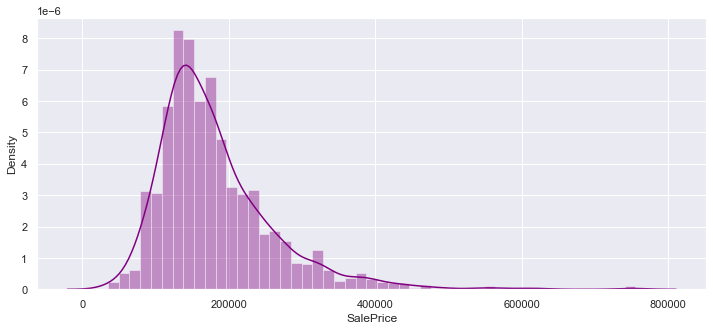

In [346]:
plt.figure(figsize = (12, 5))
sns.distplot(train_df[target], kde = True, color = 'Purple')

### 2. Examining Relationships with SalePrice

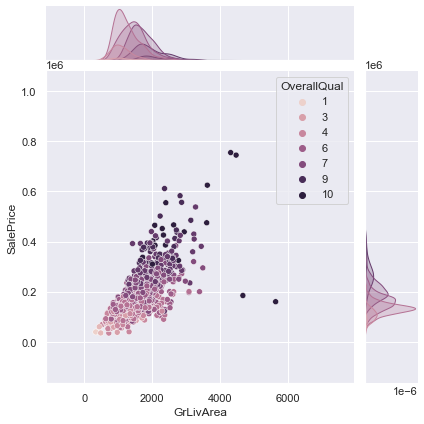

In [347]:
#GrLivArea
sns.jointplot(x = train_df["GrLivArea"], y = train_df["SalePrice"], hue = train_df["OverallQual"])

2 Outliers present!

In [348]:
outlier_idx = train_df["GrLivArea"].sort_values(ascending=False)[:2].index
train_df.drop(index = outlier_idx, inplace = True)

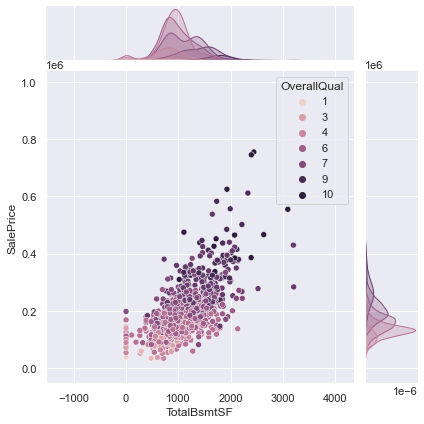

In [349]:
# TotalBsmtSF
sns.jointplot(x = train_df["TotalBsmtSF"], y = train_df["SalePrice"], hue = train_df["OverallQual"])

1 Outlier present.

In [350]:
outlier_idx = train_df["TotalBsmtSF"].sort_values(ascending=False)[:1].index
train_df.drop(index = outlier_idx, inplace = True)

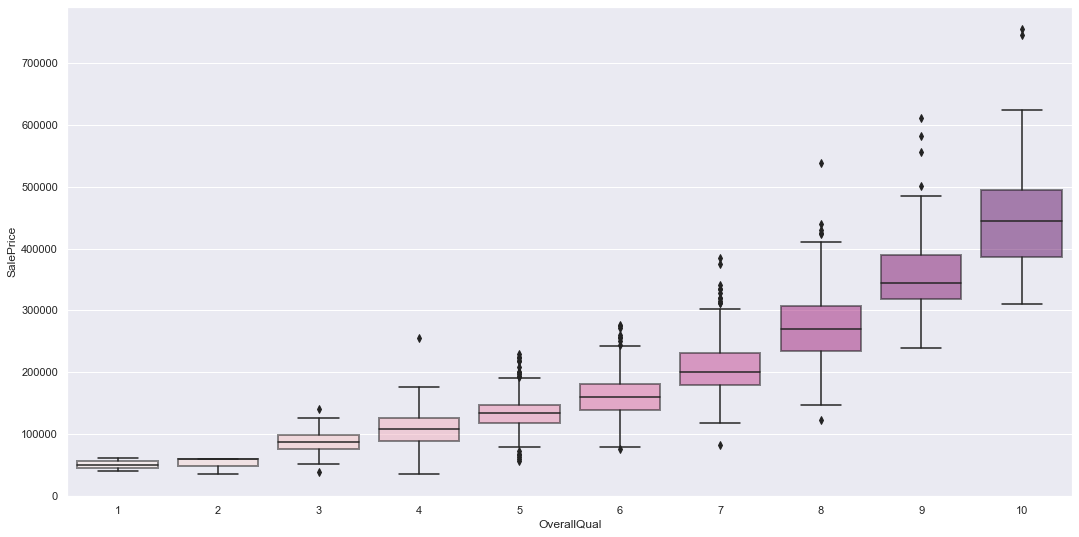

In [351]:
plt.figure(figsize = (18, 9))
ax = sns.boxplot(x='OverallQual', y='SalePrice', data=train_df, palette = "RdPu")
x = plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")

A distinct upward trend in SalePrice is observed as expected.

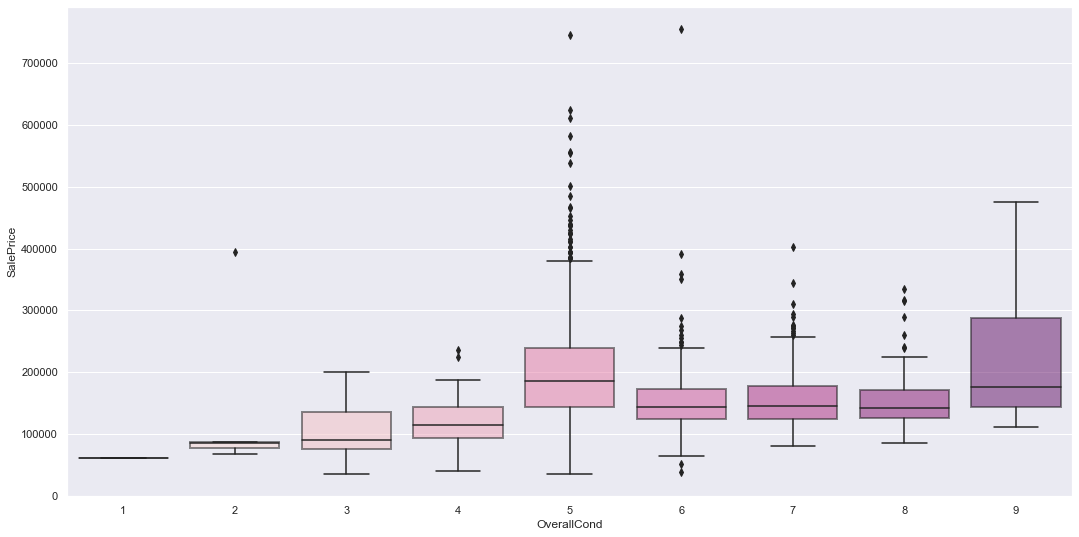

In [352]:
plt.figure(figsize = (18, 9))
ax = sns.boxplot(x='OverallCond', y='SalePrice', data=train_df, palette = "RdPu")
x = plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

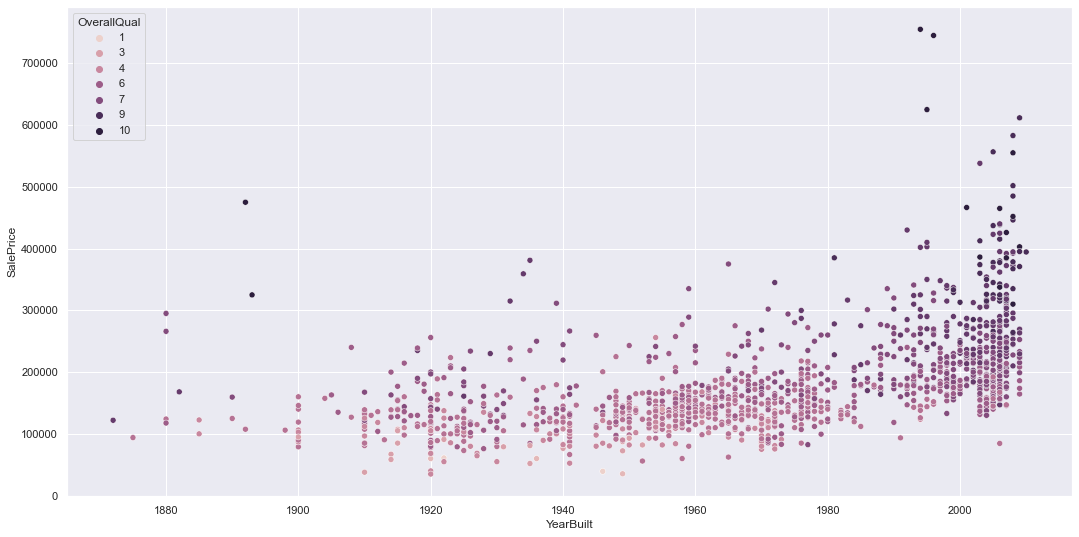

In [353]:
plt.figure(figsize=(18, 9))
sns.scatterplot(x = "YearBuilt", y = "SalePrice", data = train_df, hue = "OverallQual")

A positive correlation can is visible, but there are **too** many outliers everywhere. Using this can be risky...

### 3. **D → Target** (Discrete vs Target analysis)

Text(0.5, 1.0, 'Heatmap\n')

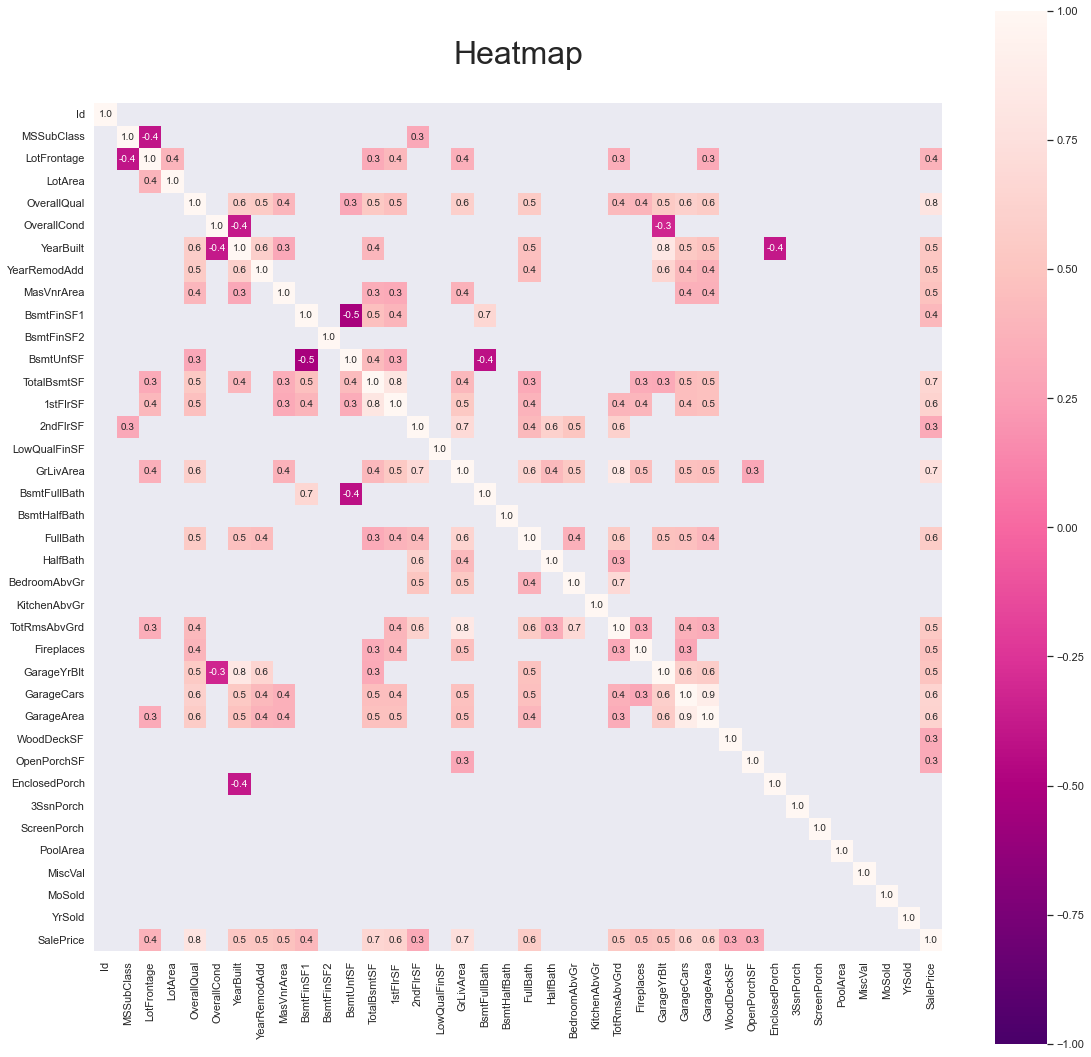

In [354]:
plt.figure(figsize = (19 , 19))
corr = train_df.corr()
sns.heatmap(corr[(corr >= 0.3) | (corr <= -0.3)], vmax=1.0, vmin=-1.0, linewidths=0,
            annot=True, square=True, fmt = ".1f", cmap = "RdPu_r");
plt.title("Heatmap\n", fontsize = 32)

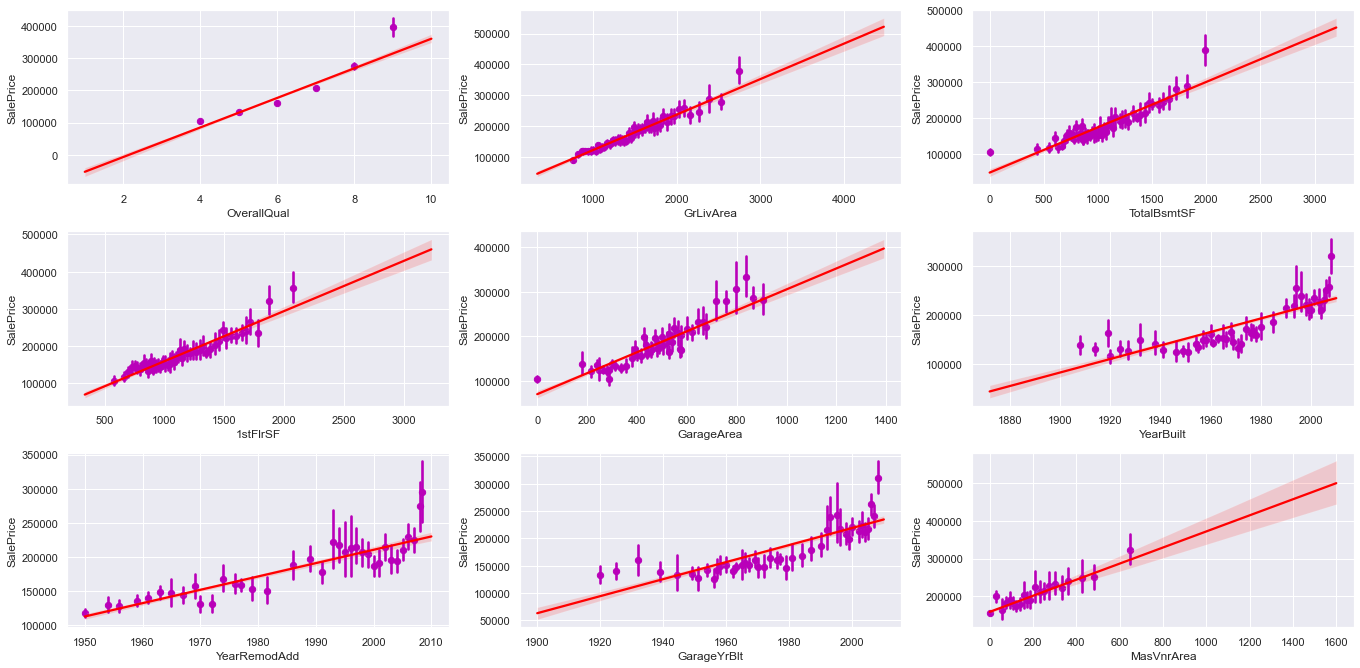

In [355]:
features = ['OverallQual', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'GarageArea','YearBuilt','YearRemodAdd', 'GarageYrBlt', 'MasVnrArea']
plt.figure(figsize = (19, 12))
plot_no = 1
for ft in features:
	plt.subplot(4, 3, plot_no)
	sns.regplot(x = ft, y = "SalePrice", data = train_df,  scatter_kws={"color" : "#B900B9", "s": 40}, line_kws={"color": "red"}, x_bins=50)
	plot_no += 1

plt.tight_layout()

### 4. **C → T** (Categorical vs Discrete Analysis)

#### Distribution of Categorical Features

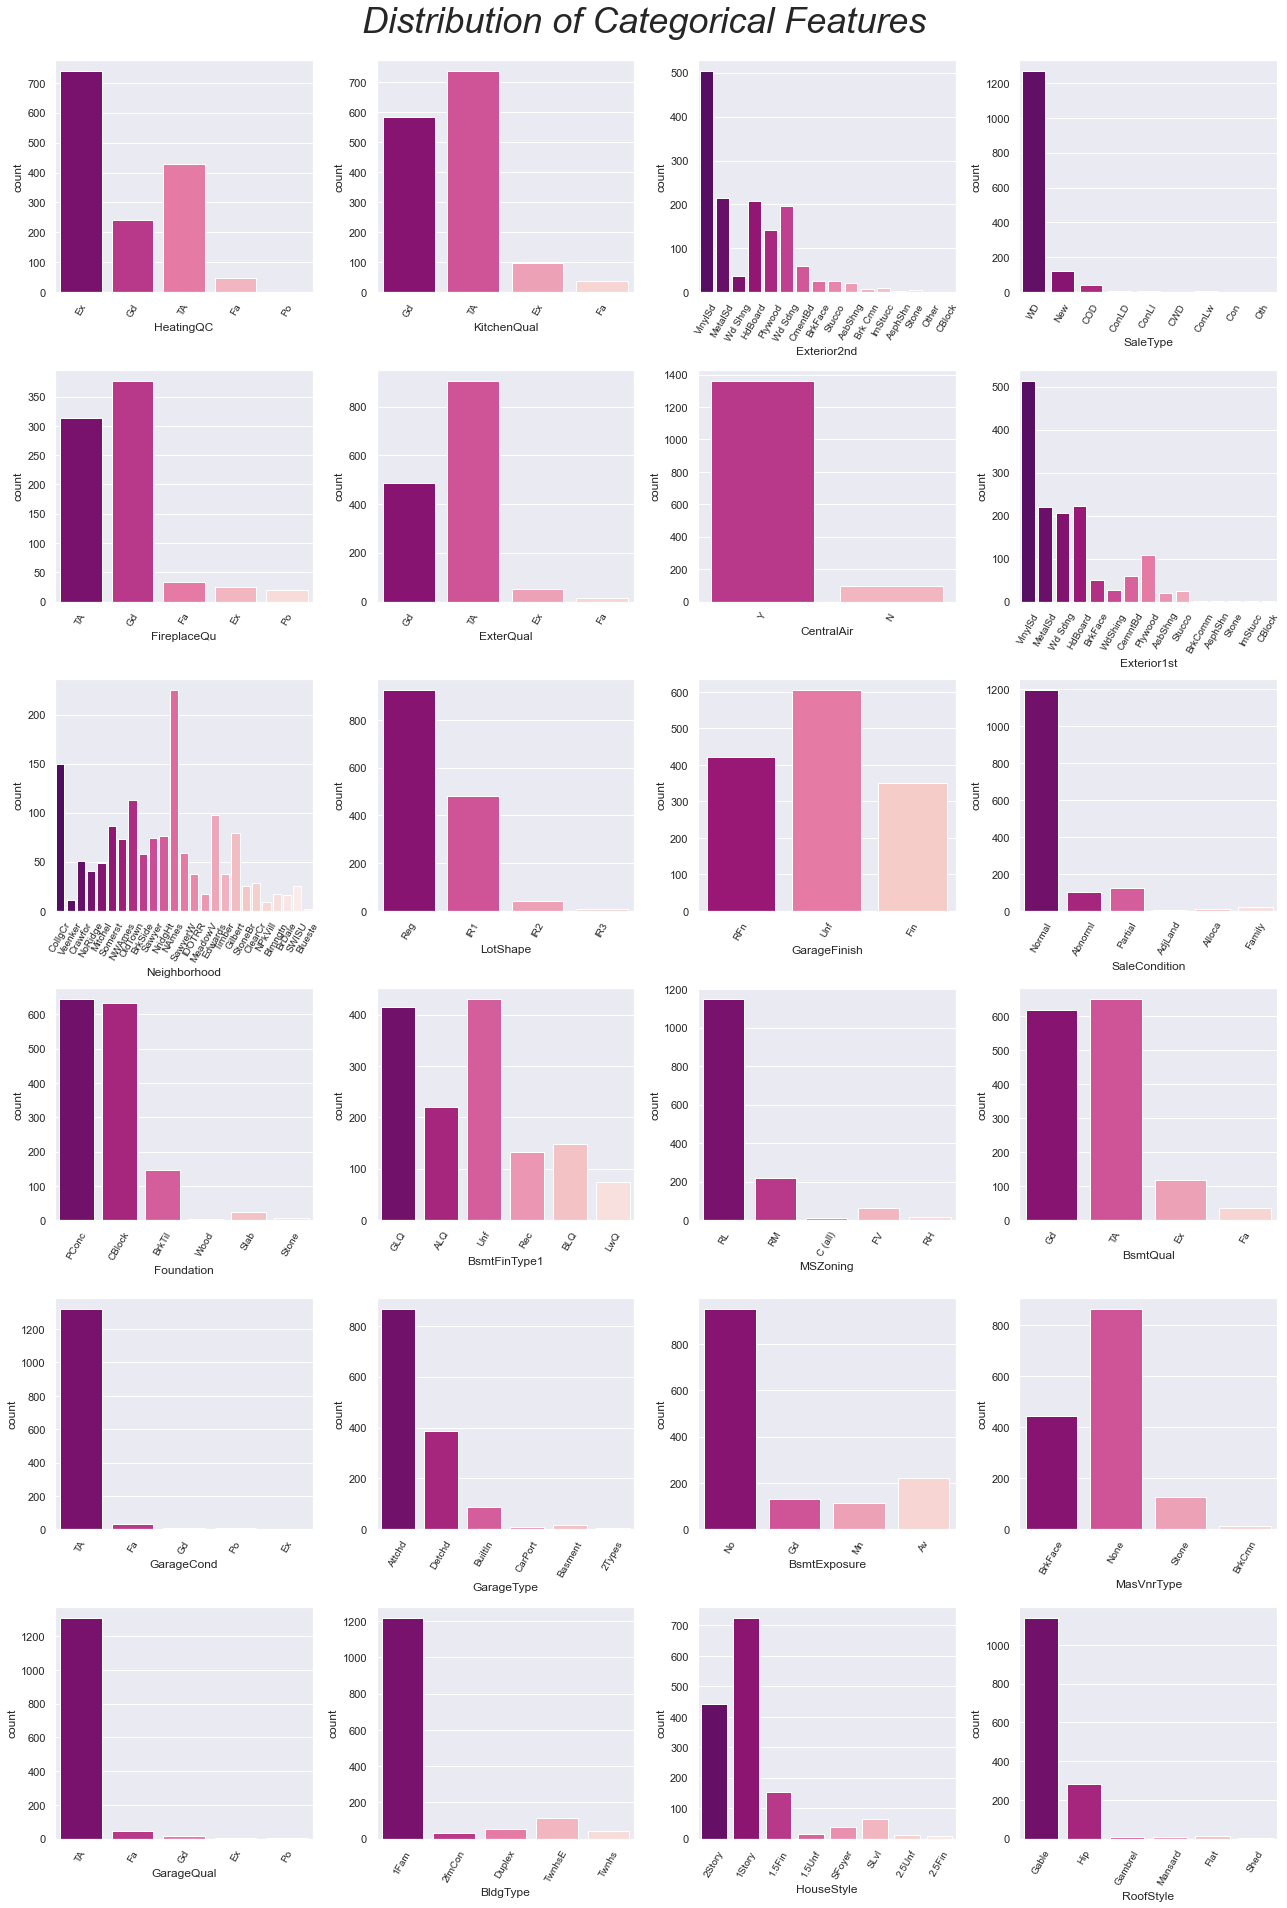

In [356]:
to_analyse = ['HeatingQC', 'KitchenQual', 'Exterior2nd', 'SaleType', 'FireplaceQu', 'ExterQual', 'CentralAir', 'Exterior1st', 'Neighborhood', 'LotShape', 'GarageFinish', 'SaleCondition', 'Foundation', 'BsmtFinType1', 'MSZoning', 'BsmtQual', 'GarageCond', 'GarageType', 'BsmtExposure', 'MasVnrType', 'GarageQual', 'BldgType', 'HouseStyle', 'RoofStyle']
plt.figure(figsize = (18, 27))
plot_no = 1
for feature in to_analyse:
	plt.subplot(6, 4, plot_no)
	sns.countplot(x = feature, data = train_df, palette="RdPu_r", )
	plt.xticks(rotation = 60, fontsize = 10)
	plot_no += 1
plt.suptitle("Distribution of Categorical Features\n", fontsize =36, style = "oblique")
plt.tight_layout()

#### Correlation with SalePrice

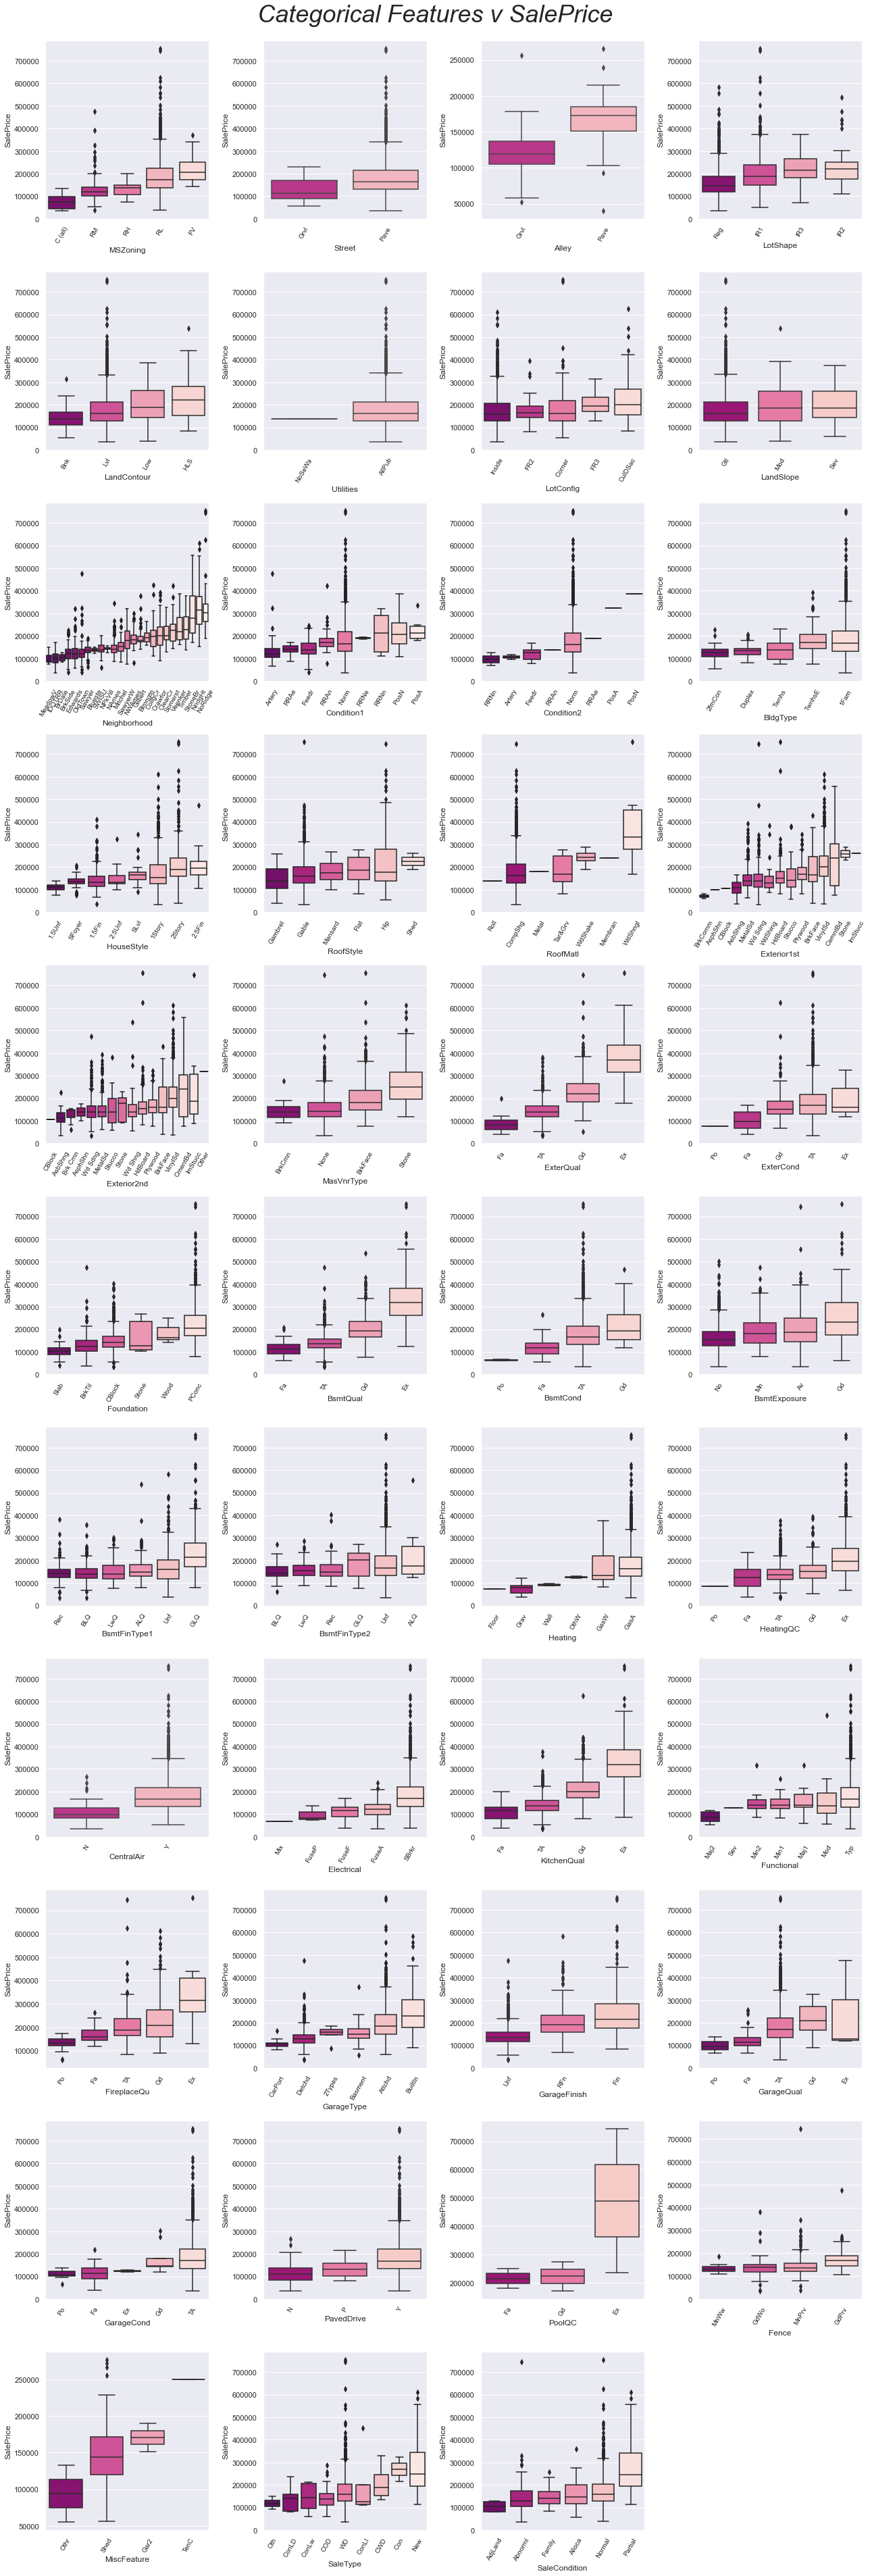

In [357]:
to_analyse = categorical
plt.figure(figsize = (18, 54))
plot_no = 1
for feature in to_analyse:
	plt.subplot(11, 4, plot_no)
	order = train_df.groupby([feature] ,as_index=False).agg({'SalePrice':'mean'}).sort_values("SalePrice")[feature].tolist()
	sns.boxplot(x = feature, y = "SalePrice", data = train_df, palette="RdPu_r",order = order)
	plt.xticks(rotation = 60, fontsize = 10)
	plot_no += 1
plt.suptitle("Categorical Features v SalePrice\n\n", fontsize =36, style = "oblique")
plt.tight_layout()

# III. Feature Selection
<hr>

### 1. Discrete Features

Text(0.5, 1.0, 'Top 15 correlated features w/ SalePrice\n')

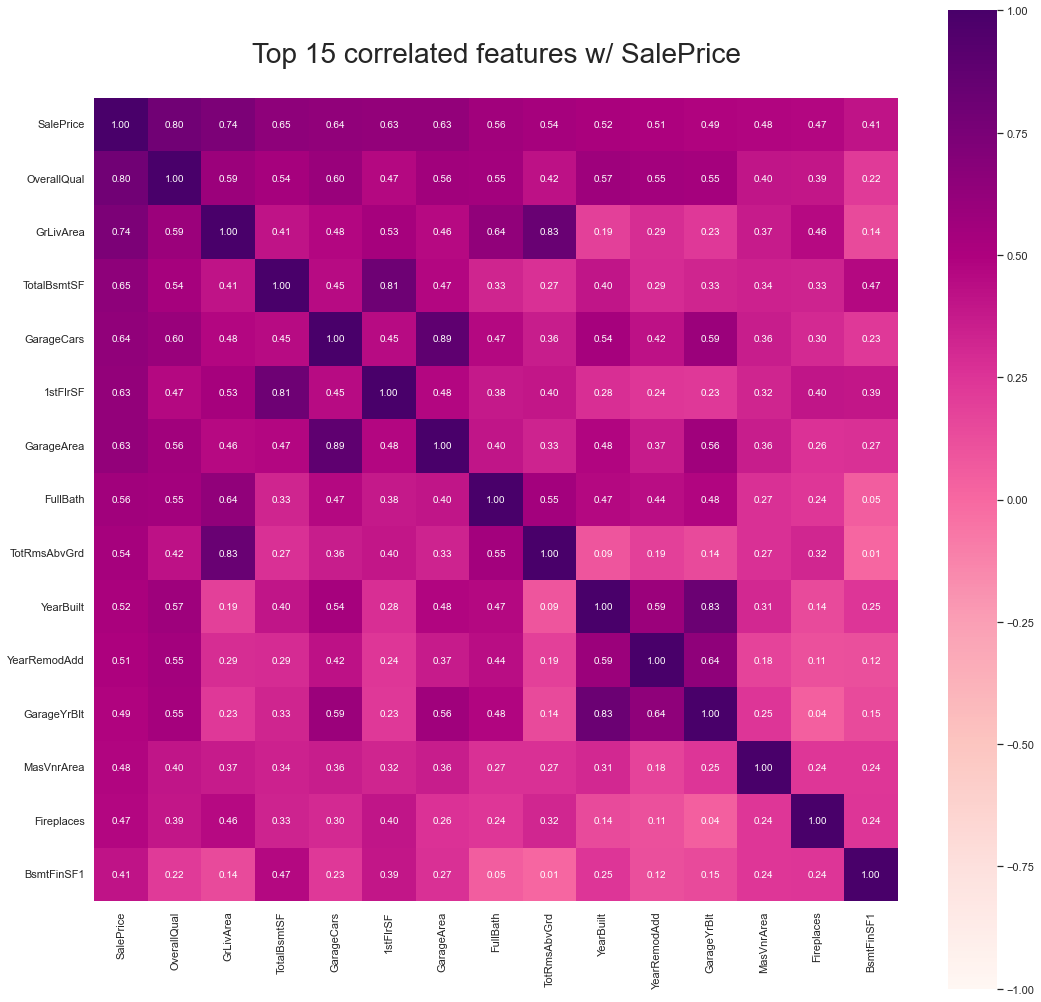

In [358]:
discrete_high_corr = get_correlated(train_df, annot=True, round_off=2, k=15, plot = False)
plt.figure(figsize = (18, 18))
sns.heatmap(train_df[discrete_high_corr.index].corr(), cmap = "RdPu", vmax=1, vmin=-1, annot = True, fmt = ".2f", square=True)
plt.title("Top 15 correlated features w/ SalePrice\n", fontsize = 28)

In [359]:
print("Highly Correlated Variables :\n {}".format(discrete_high_corr.index.tolist()))

Highly Correlated Variables :
 ['SalePrice', 'OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', '1stFlrSF', 'GarageArea', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1']


### Heatmap Analysis
- GrLivArea and TotRmsAbvGrd have a strong +ve correlation of 0.83. We can safely drop TotRmsAbvGrd.
- GarageYrBlt and YearBuilt have a strong +ve correlation of 0.83. We can safely drop GarageYrBlt.

In [360]:
discrete_high_corr.drop(index=["TotRmsAbvGrd", "GarageYrBlt"], inplace = True)

#### Distribution of top correlated features

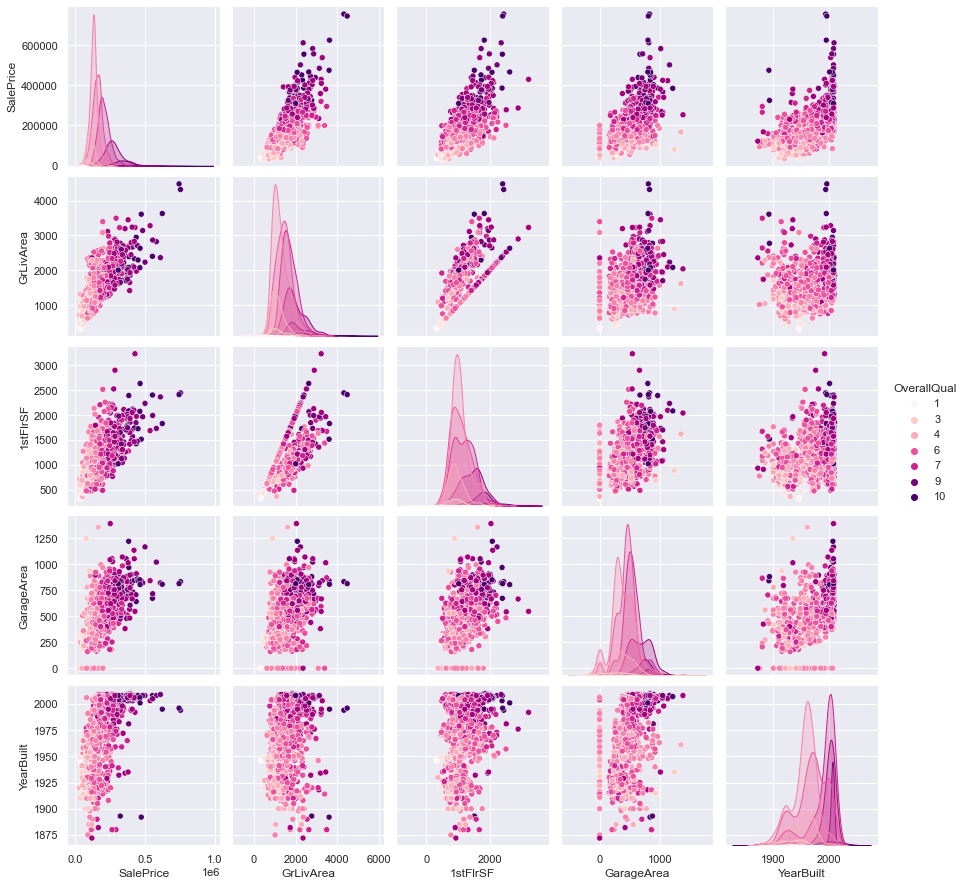

In [361]:
sns.pairplot(data = train_df[['SalePrice', 'GrLivArea', '1stFlrSF', 'GarageArea','YearBuilt', "OverallQual"]], hue="OverallQual", palette="RdPu")

It looks like apart from the strong +ve correlations with SalePrice, there are no other relations. <br> This is awesome!

### 2. Categorical Features
I'm not finding these features right now. Since Mutual Information needs all the categorical features to be OneHotEncoded, I have calculated these values later in down in the notebook, after dealing with Missing Values. After doing that I am removing thet columns here.

In [362]:
discrete_features = discrete_high_corr.index.tolist()
discrete_features.remove("SalePrice")
categorical_features = ['BsmtFinType1', 'GarageCond', 'BsmtExposure', 'BsmtQual', 'KitchenQual', 'GarageFinish', 'Neighborhood', 'MSZoning', 'ExterQual', 'GarageType', 'LotShape', 'HeatingQC', 'SaleCondition', 'SaleType', 'GarageQual', 'Exterior2nd', 'MasVnrType', 'CentralAir', 'FireplaceQu', 'Foundation', 'Exterior1st']
train_df = train_df[categorical_features + discrete_features + ["SalePrice" , "2ndFlrSF"]]
test_df = test_df [categorical_features + discrete_features + ['2ndFlrSF']]

# IV. Missing Data
<hr>

#### Combining Test and Train Dataset.
This will help deal with missing data efficiently, in both test and train data.

In [363]:
# Combining Both the dataframes, as any transformation we apply (on non-target columns)
# must be applied to both train and test.
ntrain = train_df.shape[0]
ntest = test_df.shape[0]
y_train = train_df["SalePrice"]
train_df.drop(columns = "SalePrice", inplace = True)
df = pd.concat([train_df, test_df])
print("Combined Dimensions are {}".format(df.shape))
print("y_train dimensions are {}".format(y_train.shape))
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

Combined Dimensions are (2916, 34)
y_train dimensions are (1457,)


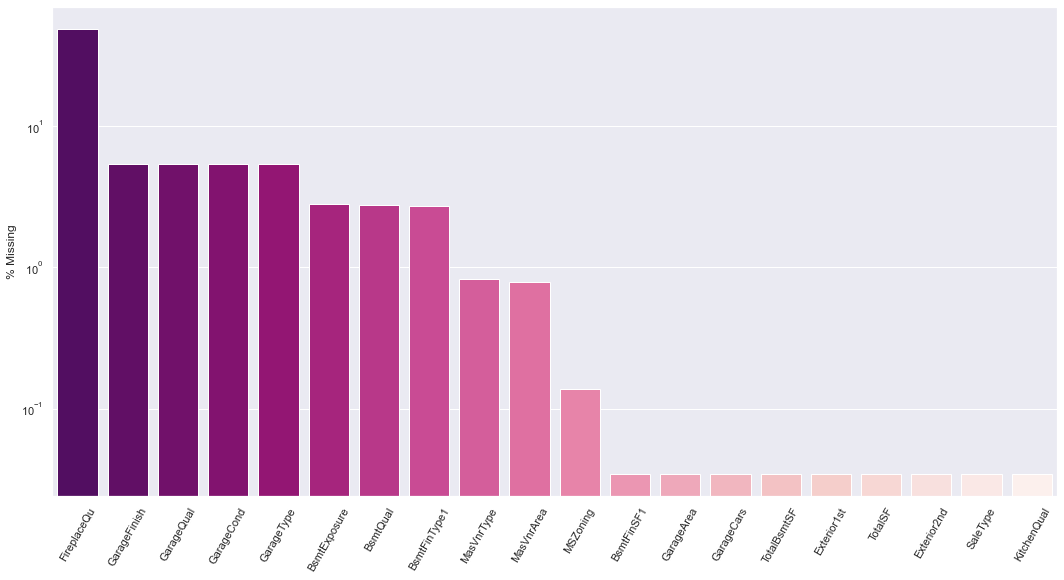

In [364]:
# Let's check how bad it is...
total = df.isnull().sum().sort_values(ascending=False)
percentage = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False) * 100

missing_data = pd.concat([total, percentage], axis=1, keys=["Total", "% Missing"])
missing_data = missing_data[missing_data["Total"] != 0]
plt.figure(figsize = (18, 9))
ax = sns.barplot(x = missing_data.index, y = missing_data["% Missing"], palette="RdPu_r")
ax.set_yscale("log")
temp = plt.xticks(rotation = 60)

- **Step 1** : Data description says that with these columns "na" actually means that the given feature is not present in the house. <br> This means that the data is not missing, the feature is.

In [365]:
# replacing na with appropriate values where na doesn't mean "data not available"
df["FireplaceQu"] = df["FireplaceQu"].fillna("None") # na means no fireplace

- **Step 2** : Dealing with all garage features.

In [366]:
# replacing values for homes without garages.
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    df[col] = df[col].fillna('None')
for col in ('GarageArea', 'GarageCars'):
    df[col] = df[col].fillna(0)

- **Step 3** : Dealing with all basement features.

In [367]:
# replacing values for homes without basements.
for col in ('BsmtQual','BsmtExposure', 'BsmtFinType1'):
    df[col] = df[col].fillna('None')
for col in ('BsmtFinSF1', 'TotalBsmtSF'):
    df[col] = df[col].fillna(0)

In [368]:
df["MasVnrType"] = df["MasVnrType"].fillna("None")
df["MasVnrArea"] = df["MasVnrArea"].fillna(0)

- **Step 4** : Replacing discrete values with median.<br> **Note** : By replacing with median of the entire dataset (test + train), data leakage occurs. But that is ultimately better for accuracy in competition.

In [369]:
missing_data = [var for var in df.columns if df[var].isnull().sum() > 0]
for var in missing_data:
    df[var] = df[var].fillna(df[var].mode()[0])

In [370]:
print("Missing cells in dataframe : {}".format(df.isnull().sum().max()))

Missing cells in dataframe : 0


These are actually categorical classes but disguised as discrete numbers. Let’s first convert them into categorical values, and then use LabelEncoder on them to prevent an inconsistencies.

In [371]:
not_discrete = []
for feature in df.columns:
    if len(df[feature].unique()) < 20 and df[feature].dtype != "object":
        df[feature] = df[feature].astype(str)
        not_discrete.append(feature)
df["YearRemodAdd"] = df["YearRemodAdd"].astype(str)
df["YearBuilt"] = df["YearBuilt"].astype(str)

In [372]:
not_discrete = not_discrete + ["YearRemodAdd", "YearBuilt"]
from sklearn.preprocessing import LabelEncoder

cols = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
        'ExterQual', 'ExterCond', 'HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond',
        'YrSold', 'MoSold']
cols = tuple(set(cols + not_discrete))
print(cols)
# process columns, apply LabelEncoder to categorical features
for c in cols:
    try:
        lbl = LabelEncoder()
        lbl.fit(list(df[c].values))
        df[c] = lbl.transform(list(df[c].values))
    except:
        pass

# shape
print('Shape all_data: {}'.format(df.shape))

('GarageQual', 'Fireplaces', 'CentralAir', 'Fence', 'ExterQual', 'KitchenQual', 'BsmtExposure', 'GarageCond', 'FullBath', 'GarageCars', 'PavedDrive', 'Functional', 'HeatingQC', 'YearRemodAdd', 'FireplaceQu', 'BsmtCond', 'PoolQC', 'Alley', 'BsmtQual', 'MSSubClass', 'BsmtFinType2', 'BsmtFinType1', 'OverallQual', 'Street', 'ExterCond', 'OverallCond', 'GarageFinish', 'LotShape', 'YrSold', 'LandSlope', 'MoSold', 'YearBuilt')
Shape all_data: (2916, 35)


# V. Normalizing and Standardizing Variables
<hr>

Let's start with SalePrice

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

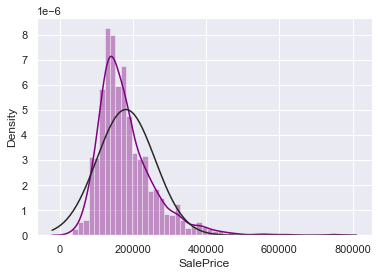

In [373]:
sns.distplot(y_train, kde = True, fit = norm, color = "purple")

<AxesSubplot:ylabel='Density'>

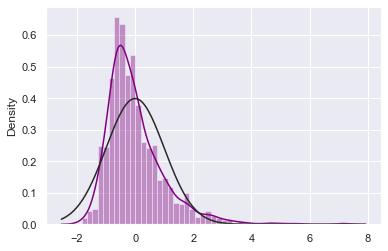

In [374]:
from sklearn import preprocessing
targetScaler = preprocessing.StandardScaler()
y_train = targetScaler.fit_transform(y_train.to_numpy().reshape(-1, 1))
sns.distplot(y_train, kde = True, fit = norm, color = "purple")

In [375]:
# Let's find the skew for all the numerical features.
numeric = [var for var in df.columns if df[var].dtype != "object"]
skewed = [df[var].skew() for var in numeric]
skewed = pd.Series(skewed, index=numeric, name="Skew").sort_values(ascending=False)

In [376]:
# Filtering out variables whose skew is greater than 0.75 (abs)
for (skew, index) in zip(skewed, skewed.index):
    if abs(skew) < 0.75:
        skewed.drop(index = index, inplace = True)
skewed

MasVnrArea      2.624917
1stFlrSF        1.259318
GrLivArea       1.069420
TotalSF         1.011794
BsmtFinSF1      0.982511
2ndFlrSF        0.861482
BsmtExposure   -1.117368
KitchenQual    -1.450849
ExterQual      -1.801850
GarageQual     -3.073687
CentralAir     -3.458600
GarageCond     -3.595389
Name: Skew, dtype: float64

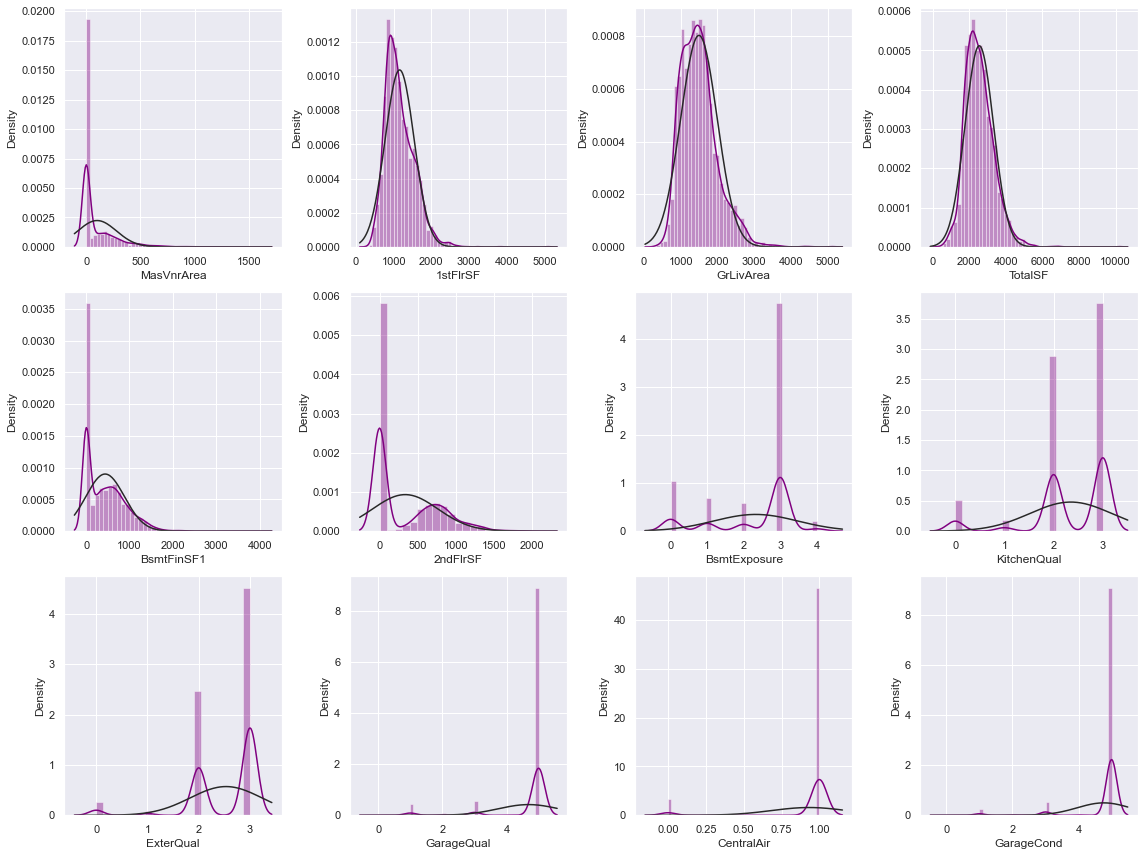

In [377]:
# Visualizing distribution.
plot_no = 0
plt.figure(figsize=(16, 12))
for feature in skewed.index:
    plt.subplot(3, 4, plot_no + 1)
    sns.distplot(df[feature], kde = True, fit=norm, color = "purple")
    plot_no += 1
plt.tight_layout()

Now that we have all the skewed features, I chose to apply log1p transformation.
log1p adds 1 to all values and then applies log. This is to prevent log(0) errors.

In [378]:
# applying log transformation to 1 + x.
df_temp = df.copy()
from scipy.special import boxcox1p
lam = 0.15
for feat in skewed.index:
    df_temp[feat] = boxcox1p(df_temp[feat], lam)

In [379]:
sc = StandardScaler()
sc.fit(df_temp.iloc[:ntrain][numeric])

StandardScaler()

In [380]:
df_temp[numeric] = sc.transform(df_temp[numeric])

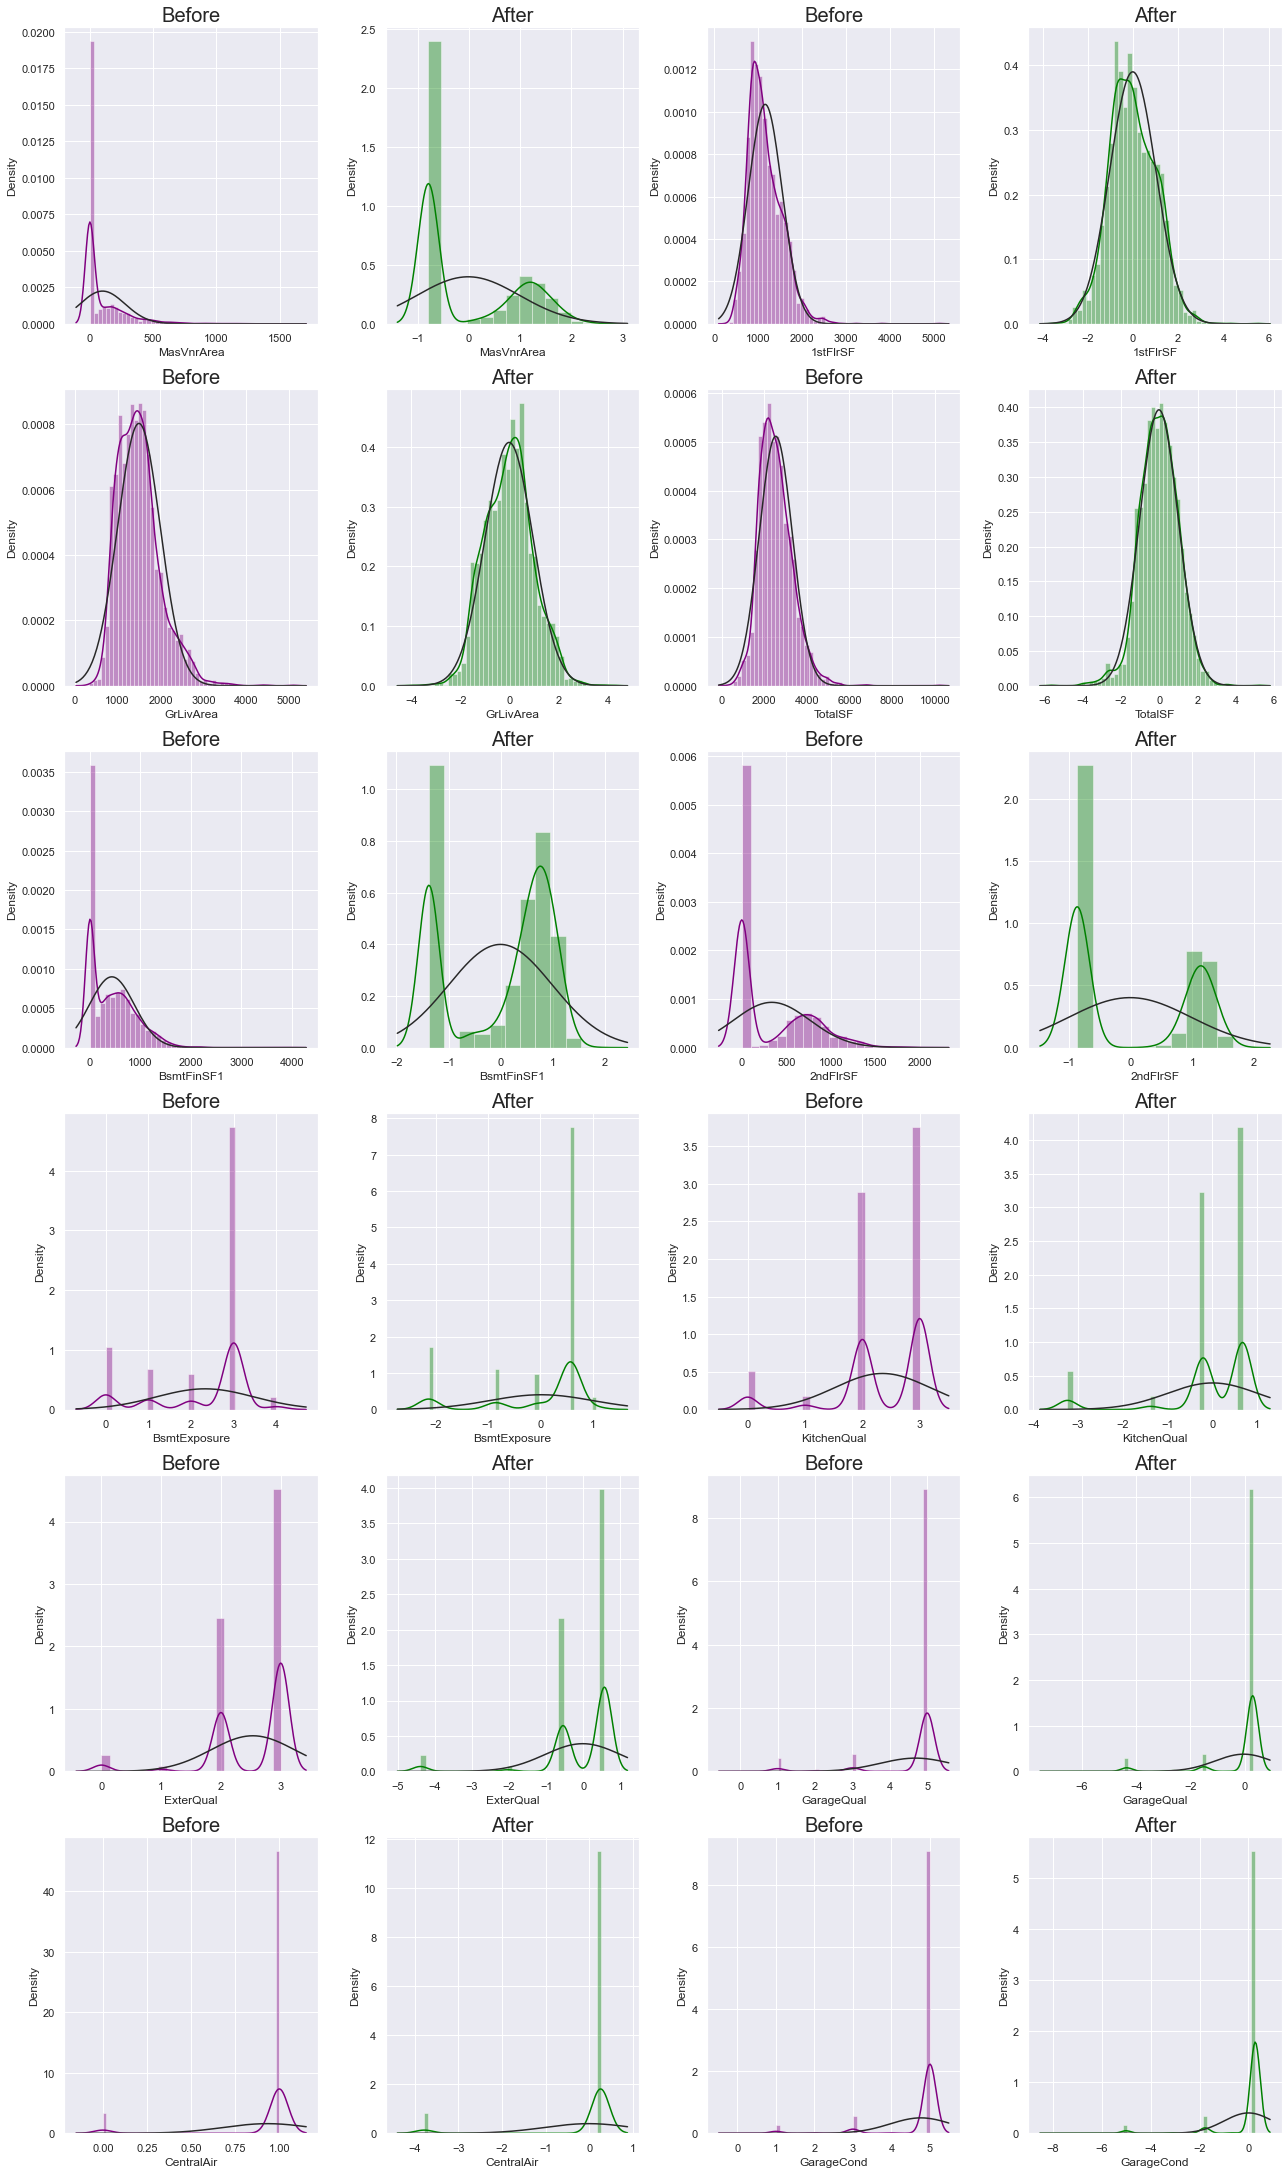

In [381]:
plot_no = 0
plt.figure(figsize=(18, 60))
for feature in skewed.index:
    plt.subplot(12, 4, plot_no + 1)
    sns.distplot(df[feature], kde = True, fit=norm, color = "purple")
    plt.title("Before", fontsize = 20)
    plt.subplot(12, 4, plot_no + 2)
    sns.distplot(df_temp[feature], kde = True, fit=norm, color = "green")
    plt.title("After", fontsize = 20)
    plot_no += 2

plt.tight_layout()

In [382]:
df = df_temp

# VI. Final Changes
<hr>

These are actually categorical classes but disguised as discrete numbers.<br> Let's first convert them into categorical values, and then use LabelEncoder on them to prevent an inconsistencies.

#### Creating Dummy Variables

In [383]:
df = pd.get_dummies(df)

In [384]:
df.shape

(2916, 119)

In [385]:
train = df[:ntrain]
test = df[ntrain:]
y = y_train

In [386]:
train.shape

(1457, 119)

### Feature Selection with Categorical Variables

In [387]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
selector = SelectKBest(mutual_info_regression, k=40)
train_new = selector.fit_transform(train, y)
mask = selector.get_support()
new_features = train.columns[mask]
print(new_features)

Index(['BsmtFinType1', 'GarageCond', 'BsmtExposure', 'BsmtQual', 'KitchenQual',
       'GarageFinish', 'ExterQual', 'LotShape', 'HeatingQC', 'GarageQual',
       'CentralAir', 'FireplaceQu', 'OverallQual', 'GrLivArea', 'TotalBsmtSF',
       'GarageCars', '1stFlrSF', 'GarageArea', 'FullBath', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1', '2ndFlrSF',
       'TotalSF', 'Neighborhood_NAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'MSZoning_RL', 'MSZoning_RM',
       'GarageType_Attchd', 'GarageType_Detchd', 'SaleCondition_Partial',
       'SaleType_New', 'Exterior2nd_VinylSd', 'MasVnrType_None',
       'Foundation_CBlock', 'Foundation_PConc', 'Exterior1st_VinylSd'],
      dtype='object')


In [388]:
categorical_high_corr = []
for ftr in new_features.tolist():
    if ftr not in discrete_high_corr.index.tolist():
        categorical_high_corr.append((ftr.split("_")[0]))
print(set(categorical_high_corr), len(categorical_high_corr))

{'GarageQual', 'MSZoning', 'CentralAir', 'GarageType', 'MasVnrType', 'ExterQual', 'Neighborhood', 'KitchenQual', 'BsmtExposure', 'GarageCond', 'HeatingQC', 'FireplaceQu', 'SaleType', 'Foundation', 'Exterior2nd', 'BsmtQual', 'Exterior1st', 'SaleCondition', 'BsmtFinType1', 'TotalSF', '2ndFlrSF', 'GarageFinish', 'LotShape'} 28


# VII. Modelling
<hr>
Let's start with basic models like Linear Regression, SVR etc, then move on to their respective improvements like Lasso Regression and finally to Ensemble Learning.


## A) Basic Modelling

In [389]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.2, random_state=97)

In [390]:
y_test = y_test.reshape(len(y_test))
y_test = targetScaler.inverse_transform(y_test)

#### Pre-defined functions for calculating metrics easily.
Ignore below code cell.

In [391]:
# Calculating R2 and Adjusted R2
def rsquared(x, y):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return r_value**2

def adj_rsquared(x, y, p):
    r = rsquared(x, y)
    n = len(x)
    return 1 - (((1 - r) * (n - 1))/(n - p - 1))
# Calculating RMSE
def mse(x, y):
    mse_score = 0
    for actual, pred, in zip(x, y):
        mse_score += (actual - pred) ** 2
    return mse_score / len(x)

# Calculating MAE
def mae(x, y):
    mae_score = 0
    for actual, pred in zip(x, y):
        mae_score += abs(actual - pred)
    return mae_score / len(x)

# Calculating root means squared of log of errors.
def rmsle(x, y):
    rmsle_score = 0
    for actual, pred in zip(x, y):
        rmsle_score += (np.log1p(actual) - np.log1p(pred)) ** 2
    return math.sqrt(rmsle_score / len(x))


**Function to rapidly train model and get results**

In [392]:
model_results = pd.DataFrame(columns=["R2", "Adj-R2", "RMSE", "RMSLE", "MAE"])

In [393]:
# automatically fit, get predictions and return results.
# Uses X_train, X_test, y_train, y_test
def fit_predict(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = targetScaler.inverse_transform(y_pred).reshape(len(y_pred))
    predict_data = pd.DataFrame({"Actual Values" : y_test, "Predicted" : y_pred})


    fig = plt.figure(figsize=(9, 9))
    sns.scatterplot(data = predict_data, x = "Actual Values", y = "Predicted", color="purple")
    sns.kdeplot(x="Actual Values", y="Predicted", data = predict_data, levels=5, color="purple", linewidths=1)
    sns.lineplot(x = [0, 700000], y = [0, 700000], color = "#0000ff", linewidth = 3)
    plt.ylim([0, 700000])
    plt.xlim([0, 700000])
    plt.title(name + "\n", fontsize = 20)
    fig.text(.5, .05, "Points closer to the blue line are more accurate.", ha = "center")

    model_results.loc[len(model_results)] = [rsquared(y_pred, y_test), adj_rsquared(y_pred, y_test, X_train.shape[1]), math.sqrt(mse(y_pred, y_test)), rmsle(y_pred, y_test), mae(y_pred, y_test)]
    indexes = model_results.index.tolist()
    indexes[len(model_results) - 1] = name
    model_results.index = indexes
    # return y_pred


### 1. Random Forest Regressor

In [394]:
# Fitting Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 500, random_state = 0)

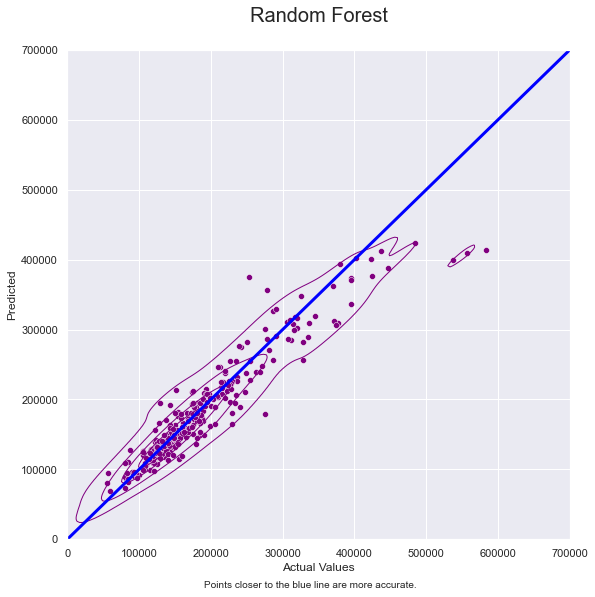

In [395]:
fit_predict(regressor, "Random Forest")

In [396]:
model_results.tail(1)

,R2,Adj-R2,RMSE,RMSLE,MAE
Random Forest,0.899926,0.830689,28127.232644,0.126492,17558.343839


### 2. Multiple Linear Regression

In [397]:
from sklearn import linear_model
lin_reg = linear_model.LinearRegression()

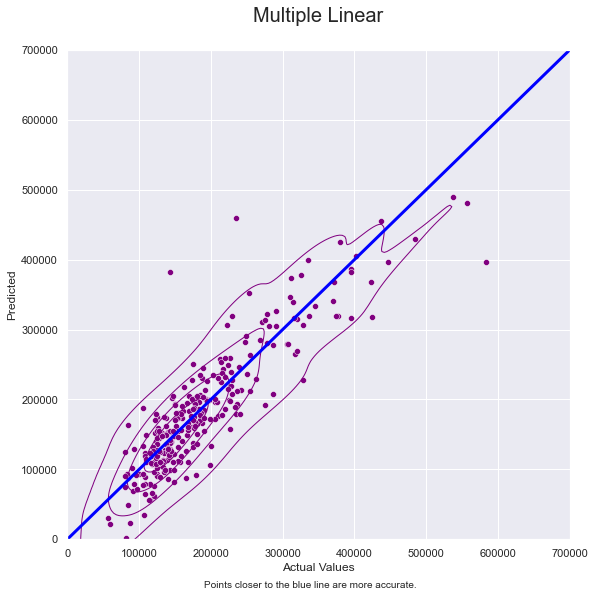

In [398]:
pred = fit_predict(lin_reg, "Multiple Linear")

In [399]:
model_results.tail(1)

,R2,Adj-R2,RMSE,RMSLE,MAE
Multiple Linear,0.785663,0.637371,41838.797056,NaN,29967.920633


### 3. Polynomial Regression

In [400]:
# first we have to raise the matrix of features to different powers.
from sklearn import preprocessing
poly_reg = preprocessing.PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(X_train)
lin_reg2 = linear_model.LinearRegression()
lin_reg2.fit(X_poly, y_train)

LinearRegression()

In [401]:
y_pred = lin_reg2.predict(poly_reg.fit_transform(X_test))
y_pred = targetScaler.inverse_transform(y_pred.reshape(len(y_pred)))

In [402]:
predict_data = pd.DataFrame({"Actual Values" : y_test, "Predicted" : y_pred})

Text(0.5, 0.05, 'Points closer to the blue line are more accurate.')

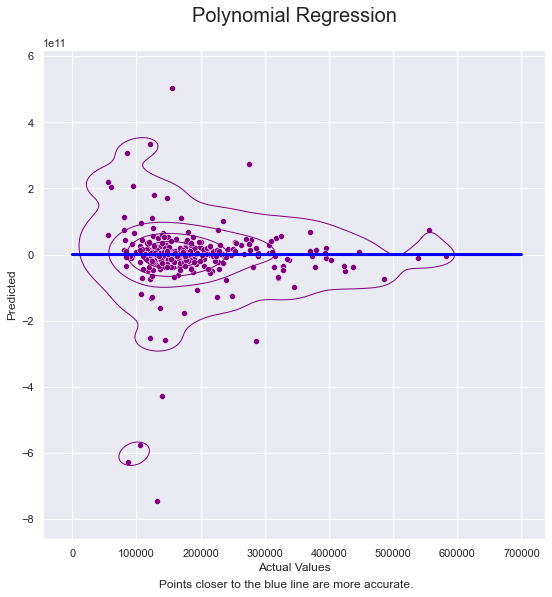

In [403]:
sns.set()
fig = plt.figure(figsize=(9, 9))
sns.scatterplot(data = predict_data, x = "Actual Values", y = "Predicted", color="purple")
sns.kdeplot(x="Actual Values", y="Predicted", data = predict_data, levels=5, color="purple", linewidths=1)
sns.lineplot(x = [0, 700000], y = [0, 700000], color = "#0000ff", linewidth = 3)
plt.title('Polynomial Regression' + "\n", fontsize = 20)
fig.text(.5, .05, "Points closer to the blue line are more accurate.", ha = "center")


<font size="+1"> Polynomial Regression is not suited for datasets with such high column count.
I'm actually not sure what happened here, because the number of columns in X_poly can be calculated by :
</font><br>
<center> features_poly = degree ** features_linear </center>
<font size="+1"> <br>
which in this case = 2 ** (200 +) which is basically infinity. <br>
Not even worth finding accuracy metrics.
</font>

In [404]:
X_poly.shape

(1165, 7260)

### 4. Support Vector Regression

In [405]:
from sklearn.svm import SVR
svr_reg = SVR(kernel='rbf')

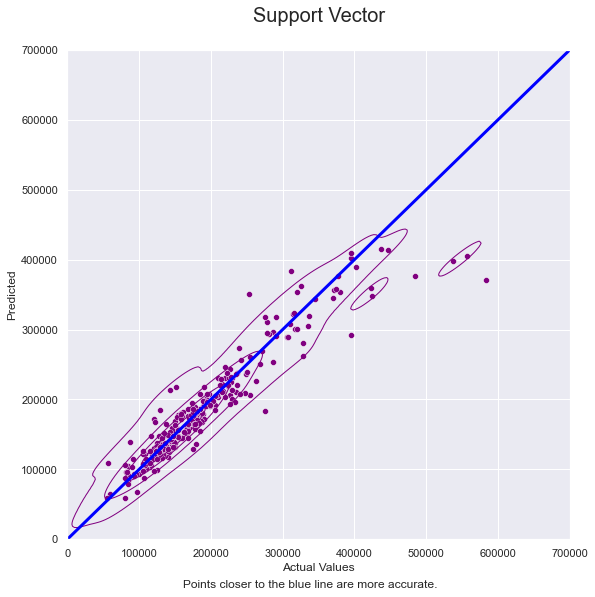

In [406]:
fit_predict(svr_reg, "Support Vector")

In [407]:
model_results.tail(1)

,R2,Adj-R2,RMSE,RMSLE,MAE
Support Vector,0.896486,0.824869,28394.742114,0.125704,16513.744598


<font size="+2"> <i> Basic regression techinques are resulting in large RMSLE and adj. R-squared errors.
Let's move on to ensemble learning. </i></font>
<hr>
<font size="+1"> <b>Conclusion</b> : Best accuracy achieved with Support Vector Regression and Random Forest Regression. </font>

## B) Advanced Modelling


Let's define cross validation functions as it will be necessary from here on.

In [408]:
# Let's introduce cross-validation.
from sklearn.model_selection import KFold, cross_val_score
def rmse_cv(model, k_fold):
    kf = KFold(k_fold, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y, scoring="neg_mean_squared_error", cv = kf))
    return (rmse)

def rmsle_cv(model, k_fold):
    kf = KFold(k_fold, shuffle=True, random_state=42).get_n_splits(train.values)
    rmsle= np.sqrt(-cross_val_score(model, train.values, y, scoring="neg_mean_squared_log_error", cv = kf))
    return (rmsle)

<h3> 5. Lasso Regression </h3>

- Lasso Regression is an improvement over Multiple Linear Regression.
- It tried to reduce overfitting and increase generalization.
- The value of alpha determines the level of generalization. At alpha = 0, Lasso Regression behaves exactly like Multiple Linear Regression.

In [409]:
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing

<font size = "+1"> Results are best at alpha = 0.01. Used Binary Search principle to arrive at this value </font>

In [410]:
lasso_reg = make_pipeline(preprocessing.RobustScaler(), Lasso(alpha=0.01, random_state=0))

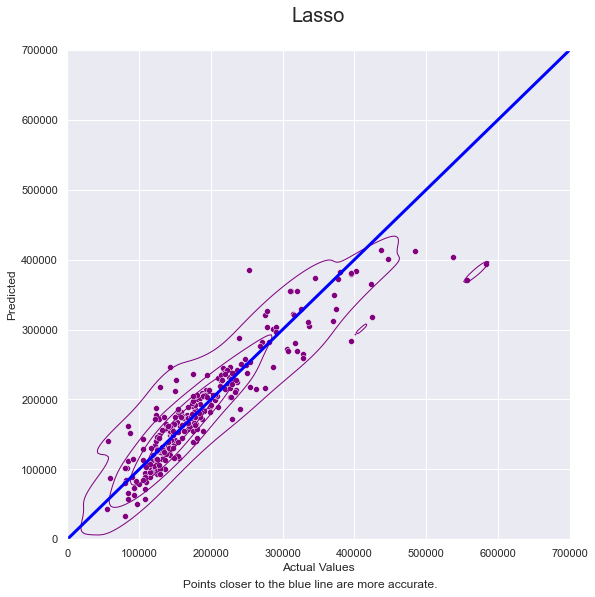

In [411]:
fit_predict(lasso_reg, "Lasso")

In [412]:
model_results.tail(1)

,R2,Adj-R2,RMSE,RMSLE,MAE
Lasso,0.848035,0.742896,33588.465991,0.185846,22166.025453


<font size="+1"> Lasso Regression behaves exactly like Linear Regression because alpha = 0. </font>

### 6. Elastic-Net Regression
Combines both ridge and lasso regression.

In [413]:
from sklearn.linear_model import ElasticNet
ENet = make_pipeline(preprocessing.RobustScaler(), ElasticNet(alpha=0.01, l1_ratio=.9, random_state=3))

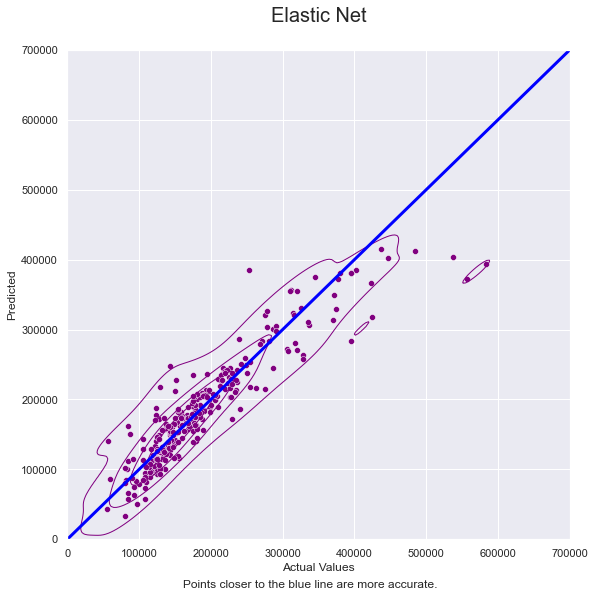

In [414]:
fit_predict(ENet, "Elastic Net")

In [415]:
model_results.tail(1)

,R2,Adj-R2,RMSE,RMSLE,MAE
Elastic Net,0.848645,0.743929,33512.120637,0.185686,22148.897275


### 7. Gradient Boost

In [416]:
from sklearn.ensemble import GradientBoostingRegressor
gboost_reg = GradientBoostingRegressor(random_state=0)

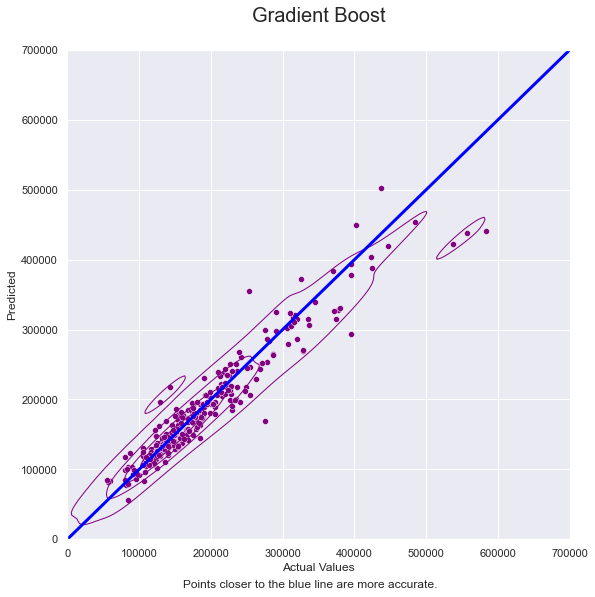

In [417]:
fit_predict(gboost_reg, "Gradient Boost")

In [418]:
model_results.tail(1)

,R2,Adj-R2,RMSE,RMSLE,MAE
Gradient Boost,0.917673,0.860715,25298.884112,0.119907,16192.888861


### 8. XGBoost Regression

In [419]:
import xgboost as xgb
xgb_reg = xgb.XGBRegressor(random_state=0)

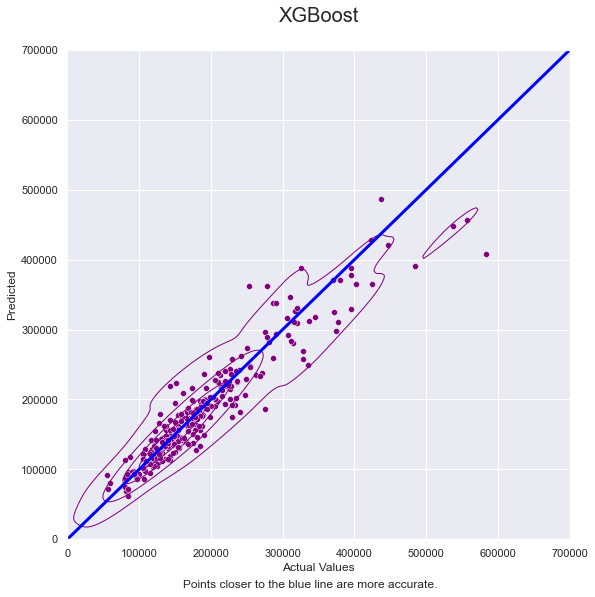

In [420]:
fit_predict(xgb_reg, "XGBoost")

In [421]:
model_results.tail(1)

,R2,Adj-R2,RMSE,RMSLE,MAE
XGBoost,0.892714,0.818487,28462.69132,0.132735,18371.371522


### 9. LightGBM Regression

In [422]:
import lightgbm as lgb
model_lgb = lgb.LGBMRegressor(random_state=0)

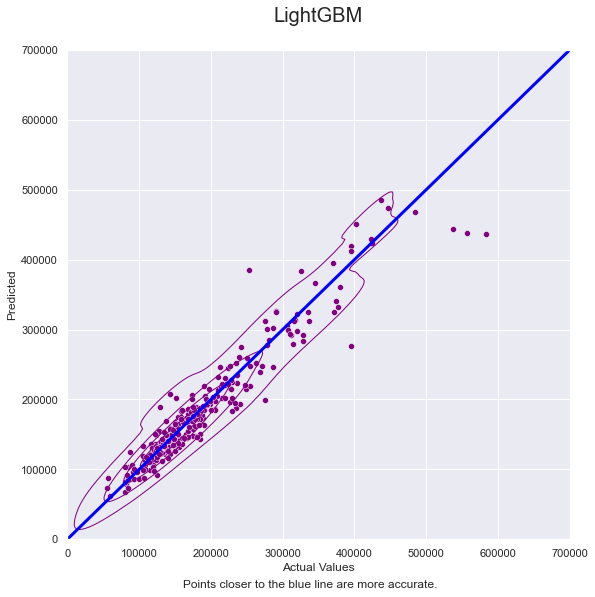

In [423]:
fit_predict(model_lgb, "LightGBM")

In [424]:
model_results.tail(1)

,R2,Adj-R2,RMSE,RMSLE,MAE
LightGBM,0.916338,0.858455,24946.271421,0.115532,15860.937419


### 10. RANSAC Regression

In [425]:
from sklearn.linear_model import RANSACRegressor
ransac_reg = RANSACRegressor()

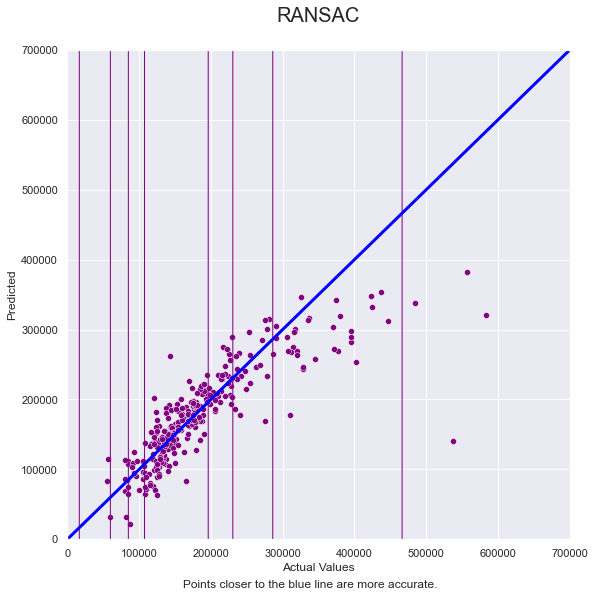

In [426]:
fit_predict(ransac_reg, "RANSAC")

Some predictions are very inaccurate. 

In [427]:
model_results.tail(1)

,R2,Adj-R2,RMSE,RMSLE,MAE
RANSAC,0.000123,-0.691652,1.366383e+16,NaN,1.147986e+15


## C) Ensemble Learning
First, let's take a look at all the performance of all the models tested.

In [428]:
model_results.sort_values("RMSLE", ascending = True)

,R2,Adj-R2,RMSE,RMSLE,MAE
LightGBM,0.916338,0.858455,2.494627e+04,0.115532,1.586094e+04
Gradient Boost,0.917673,0.860715,2.529888e+04,0.119907,1.619289e+04
Support Vector,0.896486,0.824869,2.839474e+04,0.125704,1.651374e+04
Random Forest,0.899926,0.830689,2.812723e+04,0.126492,1.755834e+04
XGBoost,0.892714,0.818487,2.846269e+04,0.132735,1.837137e+04
Elastic Net,0.848645,0.743929,3.351212e+04,0.185686,2.214890e+04
Lasso,0.848035,0.742896,3.358847e+04,0.185846,2.216603e+04
Multiple Linear,0.785663,0.637371,4.183880e+04,NaN,2.996792e+04
RANSAC,0.000123,-0.691652,1.366383e+16,NaN,1.147986e+15


Top 3 models are Gradient Boost, Random Forest, and Lasso Regression.

### Bagging (Bootstrap Aggregation)
Returns mean prediction of all given models.

In [429]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        for model in self.models_:
            model.fit(X, y)

        return self

    def predict(self, X):
        predictions = np.column_stack([
            targetScaler.inverse_transform(model.predict(X)) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [430]:
xgb_reg = xgb.XGBRegressor(random_state = 0)
gboost_reg = GradientBoostingRegressor(random_state = 0)
rfr_reg = RandomForestRegressor(n_estimators=1000, random_state=0)
lgb_reg = lgb.LGBMRegressor(random_state = 0)

bagged_model = AveragingModels(models = (rfr_reg, xgb_reg, gboost_reg, lgb_reg))

In [431]:
bagged_model.fit(X_train, y_train)
y_pred = bagged_model.predict(X_test)

Text(0.5, 0.05, 'Points closer to the blue line are more accurate.')

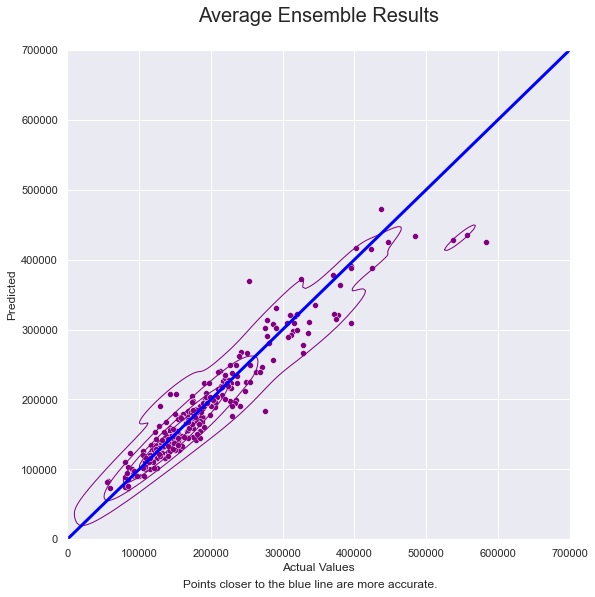

In [432]:
predict_data = pd.DataFrame({"Actual Values" : y_test, "Predicted" : y_pred})

fig = plt.figure(figsize=(9, 9))
sns.scatterplot(data = predict_data, x = "Actual Values", y = "Predicted", color="purple")
# sns.histplot(x = "Actual Values", y = "Predicted", data  = predict_data , cmap = "RdPu", thresh= 0, pthresh= 0, cbar = True)
sns.kdeplot(x="Actual Values", y="Predicted", data = predict_data, levels=5, color="purple", linewidths=1)
sns.lineplot(x = [0, 700000], y = [0, 700000], color = "#0000ff", linewidth = 3)
plt.ylim([0, 700000])
plt.xlim([0, 700000])
plt.title("Average Ensemble Results\n", fontsize = 20)
fig.text(.5, .05, "Points closer to the blue line are more accurate.", ha = "center")

In [433]:
model_results.loc[len(model_results)] = [rsquared(y_pred, y_test), adj_rsquared(y_pred, y_test, X_train.shape[1]), math.sqrt(mse(y_pred, y_test)), rmsle(y_pred, y_test), mae(y_pred, y_test)]
indexes = model_results.index.tolist()
indexes[len(model_results) - 1] = "Average Ensemble"
model_results.index = indexes
model_results.tail(1)

,R2,Adj-R2,RMSE,RMSLE,MAE
Average Ensemble,0.918329,0.861825,25167.253315,0.115544,15823.50883


# VIII. Results
<hr>

In [434]:
model_results.drop(index = "RANSAC", inplace = True)

In [435]:
model_results.sort_values("MAE", ascending=True)

,R2,Adj-R2,RMSE,RMSLE,MAE
Average Ensemble,0.918329,0.861825,25167.253315,0.115544,15823.508830
LightGBM,0.916338,0.858455,24946.271421,0.115532,15860.937419
Gradient Boost,0.917673,0.860715,25298.884112,0.119907,16192.888861
Support Vector,0.896486,0.824869,28394.742114,0.125704,16513.744598
Random Forest,0.899926,0.830689,28127.232644,0.126492,17558.343839
XGBoost,0.892714,0.818487,28462.691320,0.132735,18371.371522
Elastic Net,0.848645,0.743929,33512.120637,0.185686,22148.897275
Lasso,0.848035,0.742896,33588.465991,0.185846,22166.025453
Multiple Linear,0.785663,0.637371,41838.797056,NaN,29967.920633


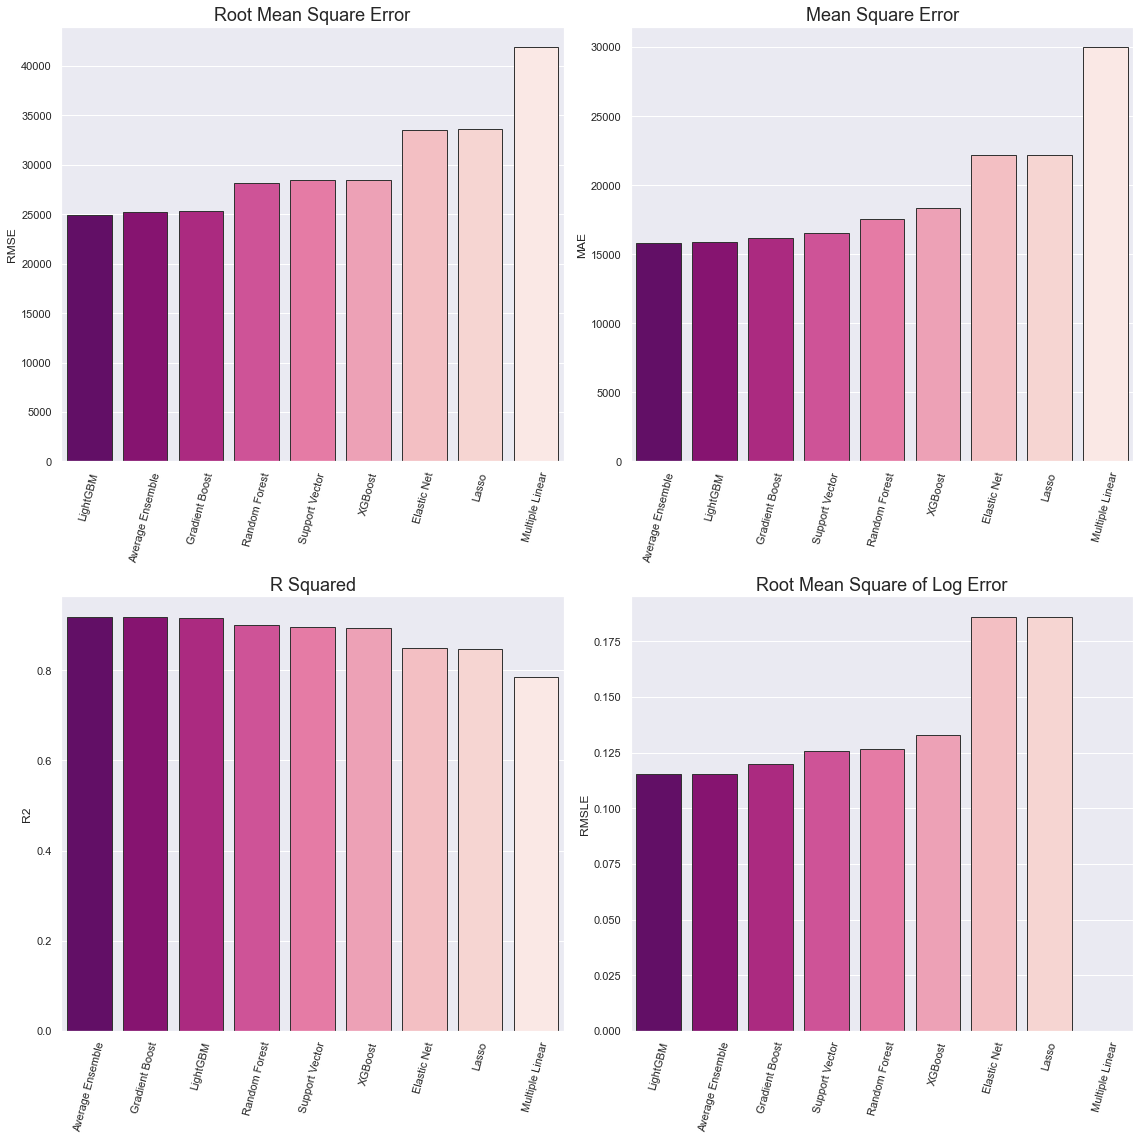

In [444]:
plt.figure(figsize=(16, 16))
plt.subplot(2, 2, 1)
plt.title("Root Mean Square Error", fontsize=18)
rmseplot = sns.barplot(y=model_results["RMSE"].sort_values(ascending=True),
                       x=model_results["RMSE"].sort_values(ascending=True).index, palette = "RdPu_r",  errcolor=".2", edgecolor=".2")
plt.xticks(rotation=75)
plt.subplot(2, 2, 2)
plt.title("Mean Square Error", fontsize=18)
maeplot = sns.barplot(y=model_results["MAE"].sort_values(ascending=True),
                      x=model_results["MAE"].sort_values(ascending=True).index, palette = "RdPu_r",  errcolor=".2", edgecolor=".2")
plt.xticks(rotation=75)
plt.subplot(2, 2, 3)
plt.title("R Squared", fontsize=18)
maeplot = sns.barplot(y=model_results["R2"].sort_values(ascending=False),
                      x=model_results["R2"].sort_values(ascending=False).index, palette = "RdPu_r",  errcolor=".2", edgecolor=".2")
plt.xticks(rotation=75)
plt.subplot(2, 2, 4)
plt.title("Root Mean Square of Log Error", fontsize=18)
maeplot = sns.barplot(y=model_results["RMSLE"].sort_values(ascending=True),
                      x=model_results["RMSLE"].sort_values(ascending=True).index, palette = "RdPu_r",  errcolor=".2", edgecolor=".2")
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

### Exporting Predictions

In [437]:
xgb_reg = xgb.XGBRegressor(random_state = 0)
gboost_reg = GradientBoostingRegressor(random_state = 0)
rfr_reg = RandomForestRegressor(n_estimators=1000, random_state=0)
lgb_reg = lgb.LGBMRegressor(random_state = 0)

bagged_model = AveragingModels(models = (rfr_reg, xgb_reg, gboost_reg, lgb_reg))

In [438]:
bagged_model.fit(train, y)

AveragingModels(models=(RandomForestRegressor(n_estimators=1000,
                                              random_state=0),
                        XGBRegressor(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                 

In [439]:
test_prediction = bagged_model.predict(test)

In [440]:
solution = pd.concat([ids, pd.Series(test_prediction)], axis=1, ignore_index=True)

In [441]:
solution.columns = ["Id", "SalePrice"]

In [442]:
solution.to_csv("solution.csv", index=False)